<a href="https://colab.research.google.com/github/mertdonmez93/Odevler/blob/main/C_06_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

İkinci proje olan regresyon projesinde kullandığınız veri kümesini tekrar kullanarak XGBoost algoritmasını kullanarak regresyon ve sınıflandırma modelleri oluşturun ve bu model için en uygun parametre değerlerini belirleyin. Projelerinizdeki modellerle karşılaştırın.

# 1. Classification with XGBOOST

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

train_data = pd.read_csv('titanic_train.csv')

In [3]:
train_data['is_male'] = pd.get_dummies(train_data['Sex'],drop_first = True)
train_data.drop(labels='Sex', axis=1, inplace=True)  

# C = Cherbourg
# S = Southampton
# Q = Queenstown
train_data.Embarked = train_data.Embarked.replace('C', 1)
train_data.Embarked = train_data.Embarked.replace('Q', 2)
train_data.Embarked = train_data.Embarked.replace('S', 3)
train_data.Embarked = train_data.Embarked.replace(np.nan, 0)

train_data.dropna(subset=['Age'], how='all', inplace=True)

In [4]:
df = train_data[['Pclass','is_male','Age','Fare','Embarked','Survived']]

In [5]:
df

,Pclass,is_male,Age,Fare,Embarked,Survived
0,3,1,22.0,7.2500,3.0,0
1,1,0,38.0,71.2833,1.0,1
2,3,0,26.0,7.9250,3.0,1
3,1,0,35.0,53.1000,3.0,1
4,3,1,35.0,8.0500,3.0,0
...,...,...,...,...,...,...
885,3,0,39.0,29.1250,2.0,0
886,2,1,27.0,13.0000,3.0,0
887,1,0,19.0,30.0000,3.0,1
889,1,1,26.0,30.0000,1.0,1


In [6]:
X = df[['Pclass','is_male','Age','Fare','Embarked']]
y = df['Survived']

In [7]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [8]:
titanic_dmatrix = xgb.DMatrix(data=X, label=y)

In [9]:
params = {"objective":"reg:logistic", "max_depth":3}

In [10]:
titanic_cv = xgb.cv(dtrain=titanic_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics="error", as_pandas=True, seed=123)
display(titanic_cv)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.177171,0.000990,0.200280,0.007142
1,0.171569,0.001981,0.194678,0.005240
2,0.167367,0.006932,0.191877,0.001980
3,0.165266,0.006024,0.191877,0.001980
4,0.162465,0.005514,0.197479,0.009077


In [11]:
print('Doğruluk Değeri : {:.3f}'.format((1-titanic_cv["test-error-mean"]).max()))

Doğruluk Değeri : 0.808


In [12]:
titanic_auc = xgb.cv(dtrain=titanic_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics="auc", as_pandas=True, seed=123)
display(titanic_auc)
print('AUC Skoru : {:.3f}'.format(titanic_auc["test-auc-mean"].max()))

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.866714,0.006546,0.854937,0.004810
1,0.873196,0.004019,0.859980,0.009696
2,0.879432,0.007380,0.859727,0.013165
3,0.886193,0.005149,0.860658,0.012265
4,0.891963,0.007673,0.857759,0.012296


AUC Skoru : 0.861


Rastgele Orman doğruluk değeri olarak 0.76 bulmuştuk..

# Regression with XGBoost

In [13]:
house_prices_df = pd.read_csv("https://djl-lms-assets.s3.eu-central-1.amazonaws.com/datasets/house_prices.csv", sep = ";")

In [14]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

houseprices_df = house_prices_df.interpolate(method ='linear', limit_direction ='forward')

df_prices = houseprices_df.filter(['OverallQual','TotalBsmtSF','1stFlrSF','GrLivArea','GarageCars','GarageArea','YearBuilt','SalePrice'], axis=1)

# Y is the target variable
y1 = df_prices['SalePrice']
# X is the feature set
X1 = df_prices[['OverallQual','TotalBsmtSF','GrLivArea','GarageCars']]

In [15]:
X1_train, X1_test, y1_train, y1_test =  train_test_split(X1, y1, test_size=0.20, random_state=111)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', seed=123)

In [16]:
from sklearn.metrics import mean_squared_error
xg_reg.fit(X1_train,y1_train)
y1_tahmin = xg_reg.predict(X1_test)
rmse = np.sqrt(mean_squared_error(y1_test, y1_tahmin))
print("RMSE: %f" % (rmse))

RMSE: 35030.118289


Oluşturduğumuz modelin rmse değerini 37513 olarak bulduk.

In [17]:
DM_train = xgb.DMatrix(data = X1_train, label=y1_train)
DM_test =  xgb.DMatrix(data = X1_test, label=y1_test)
params = {"booster":"gblinear", "objective":"reg:squarederror"}
xg_reg = xgb.train(dtrain=DM_train, params=params, num_boost_round=5)

In [18]:
y1_tahmin_gblinear = xg_reg.predict(DM_test)
rmse = np.sqrt(mean_squared_error(y1_test, y1_tahmin_gblinear))
print("RMSE: %f" % (rmse))

RMSE: 59546.345945


Oluşturduğumuz modelin rmse değerini 5972 olarak bulduk. İki modelin Kök Ortalama Kare Hataların (RMSE) karşılaştırdığımızda karar ağaçlarını zayıf öğrenme algoritması olarak kullanan modelin çok daha iyi olduğunu görüyoruz.

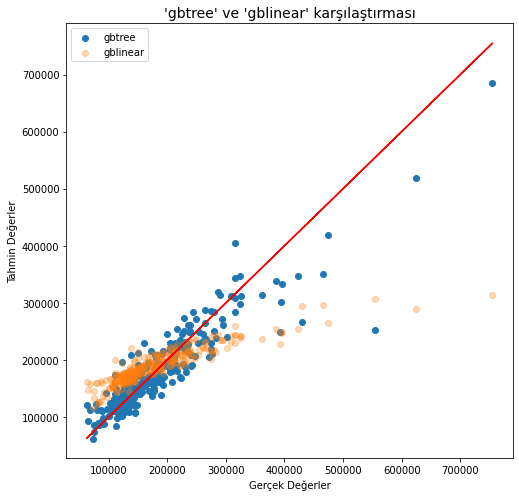

In [19]:
plt.figure(figsize=(8,8))
plt.title("'gbtree' ve 'gblinear' karşılaştırması", size = 14)
ax1 = plt.scatter(y1_test, y1_tahmin)
ax2 = plt.scatter(y1_test, y1_tahmin_gblinear, alpha=0.30)
ax3 = plt.plot(y1_test, y1_test, color="red")
plt.legend((ax1, ax2), ('gbtree', 'gblinear'))
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerler")
plt.show()

# 3. XGBoost ile model performansını artırma

# 3.1. XGBoost ile Çapraz Doğrulama

In [20]:
ev_fiyatlari_dmatrix = xgb.DMatrix(data=X1, label=y1)
params = {"objective":"reg:squarederror", "max_depth":4}
ev_fiyatlari_cv = xgb.cv(dtrain=ev_fiyatlari_dmatrix, params=params, nfold=4, 
                    num_boost_round=100, early_stopping_rounds = 5, metrics="rmse", as_pandas=True, seed=123)
display(ev_fiyatlari_cv.sort_values(by='test-rmse-mean').head(5))

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
9,25379.735351,64.898613,38021.259766,4396.419870
8,26517.142578,57.238672,38427.758789,4184.083980
7,28375.125000,128.314626,39226.827149,4208.980701
6,31512.870605,139.894227,41090.851563,3924.575879
5,36576.677734,158.514204,44972.393555,3970.588150


In [21]:
ev_fiyatlari_dmatrix = xgb.DMatrix(data=X1, label=y1)
params = {"objective":"reg:squarederror", "max_depth":4}
ev_fiyatlari_cv = xgb.cv(dtrain=ev_fiyatlari_dmatrix, params=params, nfold=4, 
                    num_boost_round=100, early_stopping_rounds = 5, metrics="mae", as_pandas=True, seed=123)
display(ev_fiyatlari_cv.sort_values(by='test-mae-mean').head(5))

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
13,17071.450684,188.126287,22434.196289,749.054194
12,17260.312988,205.656818,22482.262207,658.691237
11,17479.919433,201.965952,22508.284179,514.502155
10,17789.039551,218.647728,22648.842285,356.321450
9,18269.280762,212.280010,22860.738769,234.238977


# 3.2. XGBoost ile Regularizasyon

In [22]:
ev_fiyatlari_dmatrix = xgb.DMatrix(data=X1, label=y1)
l1_params = np.arange(0.01, 0.2, 0.01)
params = {"objective":"reg:squarederror","max_depth":3}
rmses_l1 = []
for alpha in l1_params:
    params["alpha"] = alpha
    cv_rmse = xgb.cv(dtrain=ev_fiyatlari_dmatrix, params=params, nfold=4, num_boost_round=100, 
                             metrics="rmse", as_pandas=True, early_stopping_rounds=10, seed=123)
    rmses_l1.append(cv_rmse["test-rmse-mean"].tail(1).values[0])

In [23]:
print("En iyi l1 değerleri:")
en_iyi_degerler = pd.DataFrame(list(zip(l1_params, rmses_l1)), columns=["l1", "rmse"])
display(en_iyi_degerler.sort_values('rmse').head())

En iyi l1 değerleri:


,l1,rmse
18,0.19,36421.961426
16,0.17,36421.961426
17,0.18,36421.961426
1,0.02,36421.962402
2,0.03,36421.962402


# 3.3. Hiperparametre Ayarlama

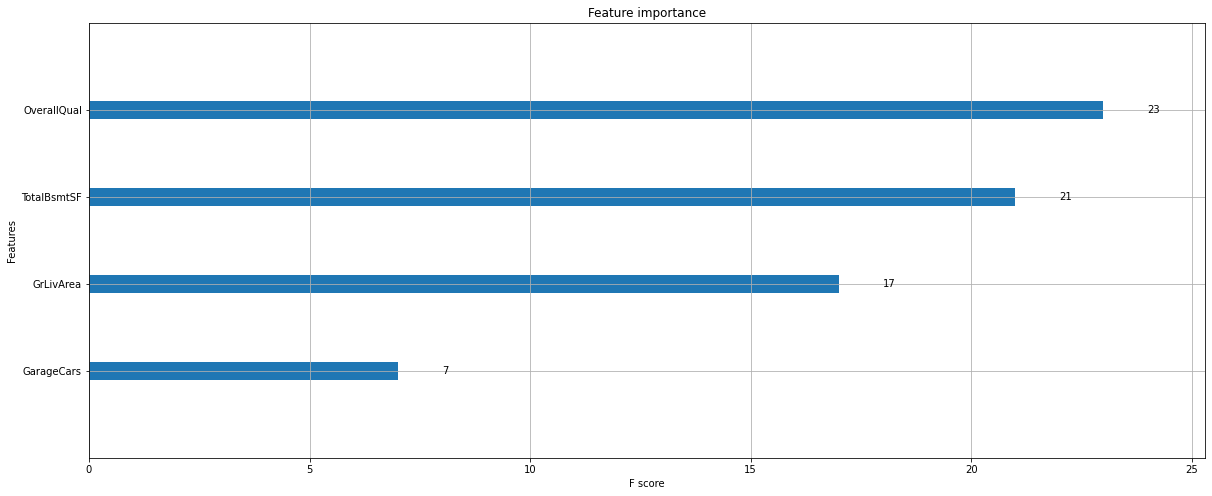

In [24]:
import matplotlib.pyplot as plt
ev_fiyatlari_dmatrix = xgb.DMatrix(data=X1, label=y1)

en_iyi_parametreler = {'objective':'reg:squarederror',
                       'colsample_bytree': 0.7, 
                       'gamma': 0.1, 
                       'learning_rate': 0.3, 
                       'max_depth': 3, 
                       'min_child_weight': 3
                      }

ev_fiyatlari_modeli = xgb.train(params=en_iyi_parametreler, dtrain=ev_fiyatlari_dmatrix, num_boost_round=10)

ax = xgb.plot_importance(ev_fiyatlari_modeli)
ax.figure.set_size_inches(20,8)
plt.show()

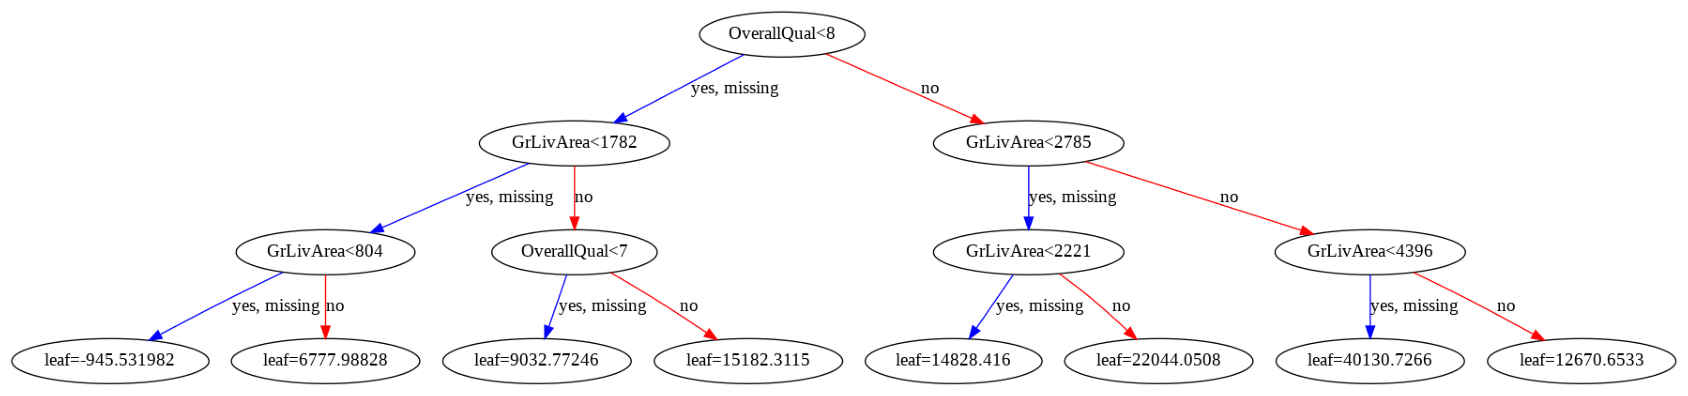

In [25]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
ax1 = xgb.plot_tree(ev_fiyatlari_modeli, num_trees=5)
ax1.figure.set_size_inches(30,30)
plt.show()